# Tiles set


####  Objective: from a .csv file containing the occurrences set, outputs:
- The reference dictionary of needed tiles:
    - {'tile_id':{'geom'  : MultiPolygon,
                'points': {gbifid: Point}
               }
      }
- A dictionary with UTM zones as keys for future extraction

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from shapely.geometry import MultiPolygon, Point, MultiPoint, GeometryCollection
from shapely.ops import unary_union
import os
from mergedeep import merge
from collections import defaultdict

## Input data

In [9]:
# Path to dictionaries to be saved
occs_p = '../data/occurrences/'
out_p  = '../data/S2_tiles'

### 1. Occurrences from .csv file

In [10]:
# read a .csv file with query occurrence coordinates
sample    = 'sample300.csv'
sample_df = pd.read_csv(os.path.join(occs_p, sample), sep=' ')

print(sample_df.shape)
sample_df.head(3)

(300, 20)


gbifid                                      occurrenceid       family  \
0  1847942808              dc41a310-e444-41c0-9f75-9bf73b9ef450  Orchidaceae   
1  1802645160  https://www.inaturalist.org/observations/8942753  Orchidaceae   
2   460140024                                               NaN  Orchidaceae   

  taxonrank         scientificname countrycode  \
0   SPECIES  Aa achalensis Schltr.          AR   
1   SPECIES  Aa achalensis Schltr.          AR   
2   SPECIES  Aa achalensis Schltr.          AR   

                                            locality  individualcount  \
0                                                NaN              NaN   
1                                                NaN              NaN   
2  Filo de la Sierra Grande, al sur del Cº Champa...              NaN   

  occurrencestatus  coordinateuncertaintyinmeters  coordinateprecision  \
0              NaN                            NaN                  NaN   
1              NaN                            NaN                  NaN   
2              NaN                            NaN                  NaN   

     year       basisofrecord                         issue canonical_name  \
0  1971.0  PRESERVED_SPECIMEN  GEODETIC_DATUM_ASSUMED_WGS84  Aa achalensis   
1  2017.0   HUMAN_OBSERVATION  GEODETIC_DATUM_ASSUMED_WGS84  Aa achalensis   
2     NaN  PRESERVED_SPECIMEN  GEODETIC_DATUM_ASSUMED_WGS84  Aa achalensis   

  genus   epitheton LEVEL3_COD  decimallongitude  decimallatitude  
0    Aa  achalensis        AGE           -64.000         -32.0000  
1    Aa  achalensis        AGE           -64.759         -31.8305  
2    Aa  achalensis        AGE           -65.100         -32.0800

- renames uniformly longitude, latitude and id columns

In [11]:
def renames_df(df, old_id, old_lon, old_lat):
    # Only keep id, lon & lat
    df = df.rename(columns={
                       old_id : 'id',
                       old_lon: 'lon',
                       old_lat: 'lat'
                      }) #[['id','lon', 'lat']]
    return df

In [12]:
sample_df = renames_df(sample_df, 'gbifid', 'decimallongitude', 'decimallatitude')
sample_df.head()

id                                      occurrenceid       family  \
0  1847942808              dc41a310-e444-41c0-9f75-9bf73b9ef450  Orchidaceae   
1  1802645160  https://www.inaturalist.org/observations/8942753  Orchidaceae   
2   460140024                                               NaN  Orchidaceae   
3  1259549774                   urn:catalog:MO:Tropicos:2254335  Orchidaceae   
4  2247702190      CORD-cf06c92f-348a-4851-a34a-c70a04c3f433-AR  Orchidaceae   

  taxonrank         scientificname countrycode  \
0   SPECIES  Aa achalensis Schltr.          AR   
1   SPECIES  Aa achalensis Schltr.          AR   
2   SPECIES  Aa achalensis Schltr.          AR   
3   SPECIES  Aa achalensis Schltr.          AR   
4   SPECIES  Aa achalensis Schltr.          AR   

                                            locality  individualcount  \
0                                                NaN              NaN   
1                                                NaN              NaN   
2  Filo de la Sierra Grande, al sur del Cº Champa...              NaN   
3  Punta sur de la Sierra de Comechingones, en Al...              NaN   
4                Cerro Blanco, camino a Los Gigantes              NaN   

  occurrencestatus  coordinateuncertaintyinmeters  coordinateprecision  \
0              NaN                            NaN                  NaN   
1              NaN                            NaN                  NaN   
2              NaN                            NaN                  NaN   
3              NaN                            NaN                  NaN   
4              NaN                            NaN                  NaN   

     year       basisofrecord                         issue canonical_name  \
0  1971.0  PRESERVED_SPECIMEN  GEODETIC_DATUM_ASSUMED_WGS84  Aa achalensis   
1  2017.0   HUMAN_OBSERVATION  GEODETIC_DATUM_ASSUMED_WGS84  Aa achalensis   
2     NaN  PRESERVED_SPECIMEN  GEODETIC_DATUM_ASSUMED_WGS84  Aa achalensis   
3  1982.0  PRESERVED_SPECIMEN  GEODETIC_DATUM_ASSUMED_WGS84  Aa achalensis   
4  1965.0  PRESERVED_SPECIMEN            COORDINATE_ROUNDED  Aa achalensis   

  genus   epitheton LEVEL3_COD      lon      lat  
0    Aa  achalensis        AGE -64.0000 -32.0000  
1    Aa  achalensis        AGE -64.7590 -31.8305  
2    Aa  achalensis        AGE -65.1000 -32.0800  
3    Aa  achalensis        AGW -64.9167 -32.6667  
4    Aa  achalensis        AGE -64.5836 -31.1986

### 2. Tiles dictionnary

In [13]:
tiles_d = np.load("../data/S2_tiles/tiles_dict.npy", allow_pickle=True).item()
print("Dict :", type(tiles_d), len(tiles_d))

Dict : <class 'dict'> 56686


## A. Dictionary of needed tiles

In [14]:
def finds_tiles(row, dico):
    """
        - row : New occ row
        - dico: Dictionary of yet unselected tiles from S2 tiling grid {tile_id, geometry}
    out:
        - D_new: Tuple list of matching tiles [(tile_id, geometry)]
    """
    # Dict of matching tiles
    D_new = dict([(k, {'geom'  : dico[k]['geom'],
                       'points': {row["id"]:row["point"]}
                       }) for k in dico if row["point"].within(dico[k]['geom'])])
    return D_new

In [15]:
def creates_tiles_set(df, t_dict, lon='lon', lat='lat', gid='id', test_points_membership=True):
    """
    From a dataframe of points and S2 tiles dictionary, provides dictionary of needed tiles.
    parameters:
        - df     : pd.Dataframe of occurrences with columns lon, lat and gid
        - t_dict : Dictionary of all tiles from S2 tiling grid {'tile_id': geometry}
    
    out:
        - D         : Dictionnary of needed tiles
                        {'tile_id':{'geom'  : MultiPolygon,
                                    'points': {gbifid: Point}
                                   }
                        }
        - L_nb_tiles: List of tiles addition per occurrences, length = #occs
    """
    # renames df
    df = renames_df(df, gid, lon, lat)
    
    # Creates Point column
    df["point"] = df[['lon', 'lat']].apply(Point, axis=1)
    
    # Test points membership
    if test_points_membership:
        # Test if all points are in tiles union
        all_points = MultiPoint(np.array(df['point']))
        # Tiles union
        U_TILES = unary_union([v['geom'] for v in tiles_d.values()])
        # Test
        if not(all_points.within(U_TILES)):
            raise ValueError("At least one point not within the tiles union, possibly intersecting it only")
        else:
            print("All points within tiles union")

    # Copy of tiles dictionary, D_othetrs containes not already selected tiles
    D_others = t_dict.copy()
    
    # Dict of needed tiles
    D = {}
    U = unary_union(D.values())
    # Counts tiles
    L_nb_tiles = []
    
    start = time.time()
    # !! Loop on occurences !!
    for i,row in df.iterrows():
        # if the new point isn't already contained in D
        if row['point'].within(U):
            # updates already selected tiles dictionary D
            D_match = finds_tiles(row, D)
        else:
            # Searches new tiles
            D_match = finds_tiles(row, D_others)
            # Compute new union
            U = unary_union([U] + [v['geom'] for v in D_match.values()])
            # Removes selected tiles from D_others
            [D_others.pop(k) for k in D_match]
        
        # Updates dictionary with match_tiles
        merge(D, D_match) 
    
        print(i,':', int((time.time() - start)//60),"mins ", int((time.time() - start)%60), "secs\t #tiles:", len(D))
        L_nb_tiles.append(len(D))
        
    return D, L_nb_tiles

In [16]:
# Fn execution
D, L_nb = creates_tiles_set(sample_df, tiles_d, test_points_membership=False)
print(len(D))

# Saves result
outfile = os.path.join(out_p, sample[:-4]+'_tiles_set_default.npz')
np.savez(outfile,
         D = D)

0 : 0 mins  0 secs	 #tiles: 2
1 : 0 mins  0 secs	 #tiles: 2
2 : 0 mins  0 secs	 #tiles: 2
3 : 0 mins  0 secs	 #tiles: 3
4 : 0 mins  0 secs	 #tiles: 4
5 : 0 mins  0 secs	 #tiles: 4
6 : 0 mins  0 secs	 #tiles: 4
7 : 0 mins  0 secs	 #tiles: 4
8 : 0 mins  1 secs	 #tiles: 8
9 : 0 mins  1 secs	 #tiles: 9
10 : 0 mins  1 secs	 #tiles: 9
11 : 0 mins  1 secs	 #tiles: 9
12 : 0 mins  1 secs	 #tiles: 10
13 : 0 mins  2 secs	 #tiles: 12
14 : 0 mins  2 secs	 #tiles: 13
15 : 0 mins  2 secs	 #tiles: 14
16 : 0 mins  3 secs	 #tiles: 15
17 : 0 mins  3 secs	 #tiles: 16
18 : 0 mins  3 secs	 #tiles: 16
19 : 0 mins  3 secs	 #tiles: 16
20 : 0 mins  3 secs	 #tiles: 18
21 : 0 mins  3 secs	 #tiles: 18
22 : 0 mins  4 secs	 #tiles: 19
23 : 0 mins  4 secs	 #tiles: 19
24 : 0 mins  4 secs	 #tiles: 20
25 : 0 mins  4 secs	 #tiles: 20
26 : 0 mins  4 secs	 #tiles: 21
27 : 0 mins  5 secs	 #tiles: 25
28 : 0 mins  5 secs	 #tiles: 25
29 : 0 mins  5 secs	 #tiles: 26
30 : 0 mins  5 secs	 #tiles: 28
31 : 0 mins  5 secs	 #tiles: 3

245 : 0 mins  35 secs	 #tiles: 156
246 : 0 mins  35 secs	 #tiles: 157
247 : 0 mins  36 secs	 #tiles: 158
248 : 0 mins  36 secs	 #tiles: 158
249 : 0 mins  36 secs	 #tiles: 158
250 : 0 mins  36 secs	 #tiles: 158
251 : 0 mins  36 secs	 #tiles: 158
252 : 0 mins  36 secs	 #tiles: 159
253 : 0 mins  36 secs	 #tiles: 159
254 : 0 mins  36 secs	 #tiles: 159
255 : 0 mins  36 secs	 #tiles: 159
256 : 0 mins  36 secs	 #tiles: 159
257 : 0 mins  36 secs	 #tiles: 159
258 : 0 mins  36 secs	 #tiles: 161
259 : 0 mins  36 secs	 #tiles: 161
260 : 0 mins  36 secs	 #tiles: 161
261 : 0 mins  36 secs	 #tiles: 162
262 : 0 mins  37 secs	 #tiles: 163
263 : 0 mins  37 secs	 #tiles: 163
264 : 0 mins  37 secs	 #tiles: 164
265 : 0 mins  37 secs	 #tiles: 165
266 : 0 mins  38 secs	 #tiles: 166
267 : 0 mins  38 secs	 #tiles: 167
268 : 0 mins  38 secs	 #tiles: 168
269 : 0 mins  39 secs	 #tiles: 170
270 : 0 mins  39 secs	 #tiles: 171
271 : 0 mins  39 secs	 #tiles: 172
272 : 0 mins  39 secs	 #tiles: 174
273 : 0 mins  39 sec

In [17]:
# Sanity check: All points within selected tiles?

# Creates Point column
sample_df["point"] = sample_df[['lon', 'lat']].apply(Point, axis=1)
# All points
all_points  = MultiPoint(sample_df.point)

if not(all_points.within(unary_union([v['geom'] for v in D.values()]))):
    raise Error("Not all points within selected tiles")

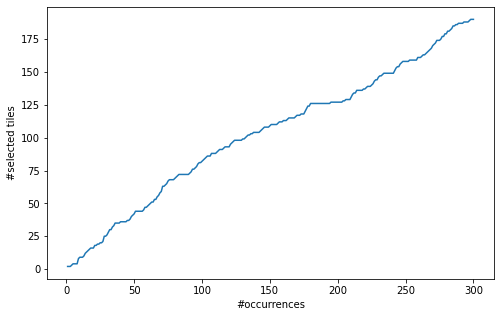

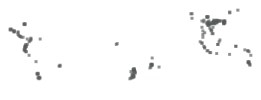

In [18]:
#Some quick plots
Nb_occs      = np.arange(1,(sample_df.shape[0]+1))

plt.figure(figsize=(8,5))
# Tiles
plt.plot(Nb_occs, L_nb)
plt.xlabel("#occurrences")
plt.ylabel("#selected tiles")
plt.show()

GeometryCollection([v['geom'] for v in D.values()])

In [19]:
# # TEST
# D = dict([('TILE1', {'geom':MultiPolygon(), 'points':{123456:Point(1,2), 45:Point(1,8)} }), 
#           ('TILE2', {'geom':MultiPolygon(), 'points':{4564:Point(3,2)} })])

# D_match = dict([('TILE1', {'geom':MultiPolygon(), 'points':{123:Point(1,2), 45:Point(2,8)} }), 
#           ('TILE3', {'geom':MultiPolygon(), 'points':{4:Point(3,2)} })])

# merge(D, D_match) 
# D

## B. Dictionary of needed tiles per UTM zone

This dictionary will allow to launch patch extraction in parallel by UTM_zone.

#### --> Create subDictionaries per UTM zone

In [20]:
# Initiates dict
D_utm = defaultdict(dict)

# Fills dict
for tile in D.keys():
    # Retrieves zone number
    utm_zone = int(tile[:2])
    # Adds tile to D_utm
    D_utm[utm_zone][tile] = D[tile]

- Test resulting dict {UTM_zone:{'tile': {'geom':MultiPolygon, 'points':{gbifid:Point}} }}

In [21]:
# list(D_utm.items())[59]

- Verifies D_utm integrity

In [22]:
Nb_tiles = 0
Nb_occs  = 0

# Changes D_utm type
D_utm = dict(D_utm)

for k in D_utm.keys():
    Nb_tiles += len(D_utm[k])
    for tile in D_utm[k]:
        Nb_occs += len(D_utm[k][tile]["points"])

print("type(D_utm):", type(D_utm),",  len(D_utm):", len(D_utm))
print("Nb_tiles:", Nb_tiles)
print("Nb_occs:", Nb_occs)

type(D_utm): <class 'dict'> ,  len(D_utm): 23
Nb_tiles: 190
Nb_occs: 400


- Saves dict

In [23]:
outfile = os.path.join(out_p, 'D_utm.npz')
np.savez(outfile, D = D_utm)

- Loads it

In [7]:
# data          = np.load(outfile, allow_pickle=True)
# D_utm_loaded  = data['D'].item()

# D_utm_loaded[55].keys()

dict_keys(['55MBQ', '55MCP', '55KCA', '55KDU', '55KDV', '55KCB', '55LCC', '55KBB', '55LBC', '55LEK', '55KFS', '55KCV', '55MBN', '55MCN', '55LEL', '55MDM', '55MDN', '55MDP', '55LDL', '55MEN', '55LGJ', '55LGK', '55KHQ', '55KFT', '55MBP', '55LHK', '55TCJ', '55TCH', '55MCQ', '55HGA', '55HGV', '55HDE', '55HEE', '55MCM', '55MEP', '55HCU', '55HCD', '55HGU', '55KFP', '55KGP', '55HBS', '55HBT', '55JGG', '55JFF', '55GEN', '55GEQ', '55GFQ', '55GEP', '55GFP', '55HEU', '55HDS', '55HCT', '55HFU', '55HDT', '55HDV', '55HEV', '55HFA', '55HGC', '55HDU', '55GDN', '55HBU', '55JFN', '55HFB', '55JEK', '55JFK', '55TEK', '55MEM', '55GBQ', '55GCQ', '55GBR', '55HES', '55GER', '55HCV', '55GCR', '55GDQ', '55GDM', '55HBV', '55HET', '55HEA', '55GCP', '55HFV', '55HDC', '55HDB', '55HFE', '55HFD', '55HEB', '55HFC', '55GDP', '55HDA', '55HCA', '55HED', '55JCF', '55HGB', '55HGD', '55GCN', '55GFR', '55KBT', '55HBA', '55JGF', '55HEC', '55HGE', '55LBD', '55KBU', '55LFK', '55KGS', '55KGQ', '55KGR', '55KET', '55JGK', '55JFG',